# Report - Navigation Project

## Learning Algorithm


A simplified version of a Deep Q Network have been used in this project. 
Deep Q Networks are based on the traditional off-policy algorithm Sarsamax (or Q-learning), but instead of using a table for storing the action-state values, it uses a deep neural network that learns to predict these. In general, using non-linear approximators for Q-learning have been proven unstable and unfit. However, DeepMind came up with a couple of improvements that improve the stability of the learning progress, making Deep Q Networks a viable solution for mapping actions to large state-spaces.

Starting with the neural network, the agent makes use of a simple multi-layer perceptron network with 2 layers of 64 units each and relu activations.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MlpPolicy(nn.Module):

    def __init__(self, state_size, action_size, seed=0):
        super(MlpPolicy, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

One of the first improvements was to reduce the correlation in the sampled data. The solution was to create an episode database from wich the algorithm can retrieve random experiences and reduce the learning problem to a supervised learning problem: map (s,a,r,s') sequences to actions. 

The agent uses a simplified replay buffer which stores (s,a,r,s') tuples. Once it has enough experiences in the memory to sample from (larger than batch number) the buffer is able to output these in randomized batches. 

In [ ]:
class ReplayBuffer:

    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        self.memory.append(self.experience(state, action, reward, next_state, done))
    
    def sample(self):
        experience_batch = random.sample(self.memory, k=self.batch_size)

        # Separate and move data on the GPU
        states = torch.from_numpy(np.vstack([e.state for e in experience_batch if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experience_batch if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experience_batch if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experience_batch if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experience_batch if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

The hyperparameters were inspired from the toy examples build during the chapter, as well as the DQN paper. As the state-spaces is smaller than mapping directly from pixels, we let the replay buffer size be 100.000. This also allows us to use a larger batch size of 64 (double from the original paper) while we keep the discount factor and update frequency the same. Learning rate has also doubled. The soft update hyper-parameter was chosen from a previous toy example.

In [ ]:
BUFFER_SIZE = 100000    # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 0.001             # for soft update of target parameters
LR = 0.0005             # learning rate 
UPDATE_EVERY = 4        # how often to update the network

Another improvement brought by the paper is the use of a target network. As our target values were highly correlated to the predicted ones (sharing the same parameters) this made learning very unstable. A solution was to use 2 networks, a local one (which is updated every 'x' steps) and a target network (which changes much more slowly). Therefore, we use the local network to predict the current value and target network to retrieve the old value of the state.

The loss function is a hybrid of MSE and Bellman backup operators. The 'target' value will be the reward received + discounted max return of the next state (all predicted by target network) while the 'predicted' value is simply the outupt of the local network, given the current state.

Finally, we 'soft update' the target network at every gradient descent update. That means we slowly modify the weights of the target network towards the ones of the local network, while the amount of change is controlled by the TAU hyper-parameter.

In [ ]:
from policies import MlpPolicy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class DQN:

    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Networks and optimizer
        self.local_network = MlpPolicy(state_size, action_size, seed).to(device)
        self.target_network = MlpPolicy(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.local_network.parameters(), lr=LR)

        # Replay memory
        self.replay_buffer = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.t_step = 0
        self.ok = 1
    
    def step(self, state, action, reward, next_state, done):
        self.replay_buffer.add(state, action, reward, next_state, done)
        self.t_step += 1

        if self.t_step % UPDATE_EVERY == 0:
            if len(self.replay_buffer) > BATCH_SIZE:   # if enough samples
                self.learn(self.replay_buffer.sample(), GAMMA)



    def predict(self, state, eps=0.):
        """Returns action from e-greedy policy"""
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)

        # Forward pass (no gradient)
        self.local_network.eval()
        with torch.no_grad():
            action_values = self.local_network(state)
        self.local_network.train()

        # Action pick
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experience_batch, gamma):
        states, actions, rewards, next_states, dones = experience_batch

        # Get vector of max predicted Q values for next states (from target model)
        # 'max' gets you [64,1], 'unsqueeze' and get [64]
        Q_targets_next = self.target_network(next_states).detach().max(1)[0].unsqueeze(1)
        
        # Compute Q targets for current states
        Q_targets = rewards + (gamma*Q_targets_next*(1-dones))

        # Get predicted Q values from local model
        Q_predictions = self.local_network(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_predictions, Q_targets)
        
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        self.soft_update(self.local_network, self.target_network, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Slowly update target model's parameters."""
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

## Training
The algorithm managed to reach a score over 13 points in just 429 episodes. The following plot showcases the evolution of the reward in time.


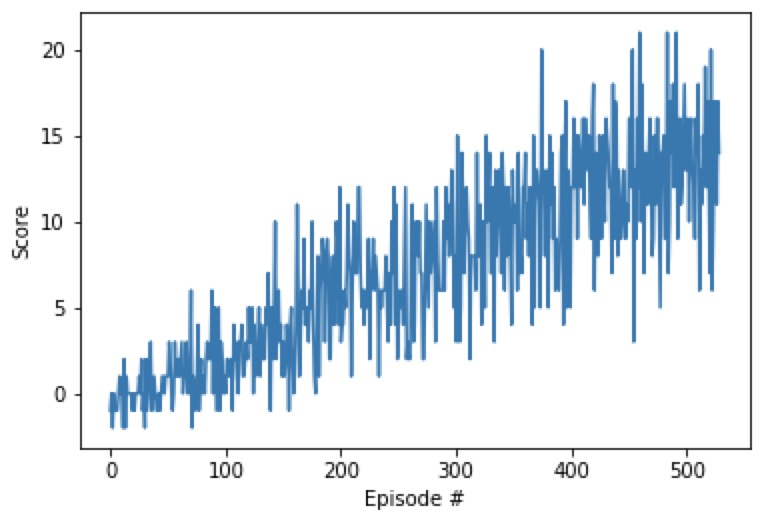

## Future Ideas of improvement
As previously mentioned, this is a simplified version of the vanilla DQN algorithm. There are many problems with this algorithm, such as the slower convergence rate due to overestimating the values of the states [1] and not knowing what experience is more important, wasting a lot of time with experiences it has already learned well [2].

The next steps will be to further improve the algroithm by adding more advanced features such as Double Q-learning, Prioritized Replay and Dueling Networks.


## References
[1] van Hasselt, H.; Guez, A.; and Silver, D. 2016. Deep re- inforcement learning with double Q-learning. In Proc. of AAAI, 2094–2100.

[2] Schaul, T.; Quan, J.; Antonoglou, I.; and Silver, D. 2015. Prioritized experience replay. In Proc. of ICLR.